<a href="https://colab.research.google.com/github/shobhittya/deeplearning/blob/main/InceptionResnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [3]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

'2.6.0'

In [5]:
!pip install opendatasets --upgrade --quiet

In [6]:
import opendatasets as od

In [7]:
dataset_url = "https://www.kaggle.com/sophatvathana/casia-dataset"

In [8]:
import os

In [9]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shobhittyagi
Your Kaggle Key: ··········


100%|██████████| 5.22G/5.22G [01:39<00:00, 56.1MB/s]


In [10]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt2
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout)
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from keras import regularizers
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau

In [11]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [12]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [13]:
image_size = (128, 128)

In [14]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [15]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [16]:
import random
path = '/content/casia-dataset/CASIA2/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [17]:
path = '/content/casia-dataset/CASIA2/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [18]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [19]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import backend as K

pretrain_model = InceptionResNetV2(include_top=False,  weights='imagenet', input_shape=(128, 128, 3))  

def create_model(input_shape, n_out):
    
    pretrain_model = InceptionResNetV2(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)       
    
    input_tensor = Input(shape=(128, 128, 3))
    bn = BatchNormalization()(input_tensor)
    x = pretrain_model(bn)
    x = Conv2D(128, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    return model

    # input_tensor = Input(shape=input_shape)
    # bn = BatchNormalization()(input_tensor)
    # x = pretrain_model(bn)
    # x = Conv2D(128, kernel_size=(1,1), activation='rel
    # model = Model(input_tensor, output)

219070464/219055592 [==============================] - 2s 0us/step


In [23]:
keras.backend.clear_session()

model = create_model((128, 128, 3), 2)


model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
batch_normalization_203 (Bat (None, 128, 128, 3)       12        
_________________________________________________________________
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 2, 2, 128)         196736    
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656

In [26]:
epochs = 30
batch_size = 32

In [27]:
init_lr = 1e-4
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [28]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [29]:
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [31]:
checkpoint = ModelCheckpoint(filepath='/content/Model_weights/IRnet.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              verbose=1
                             )
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, early_stopping, csv_logger]

In [32]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                 validation_data = (X_val, Y_val),
                 callbacks = callbacks)

Epoch 1/30
105/105 [==============================] - 119s 635ms/step - loss: 0.5358 - accuracy: 0.7460 - val_loss: 2.1929 - val_accuracy: 0.5390

Epoch 00001: val_loss improved from inf to 2.19290, saving model to /content/Model_weights/IRnet.h5
Epoch 2/30
105/105 [==============================] - 60s 569ms/step - loss: 0.2940 - accuracy: 0.8910 - val_loss: 268.1002 - val_accuracy: 0.6134

Epoch 00002: val_loss did not improve from 2.19290
Epoch 3/30
105/105 [==============================] - 60s 570ms/step - loss: 0.1817 - accuracy: 0.9301 - val_loss: 0.5588 - val_accuracy: 0.7515

Epoch 00003: val_loss improved from 2.19290 to 0.55882, saving model to /content/Model_weights/IRnet.h5
Epoch 4/30
105/105 [==============================] - 60s 570ms/step - loss: 0.0715 - accuracy: 0.9745 - val_loss: 2.6047 - val_accuracy: 0.8295

Epoch 00004: val_loss did not improve from 0.55882
Epoch 5/30
105/105 [==============================] - 61s 578ms/step - loss: 0.0820 - accuracy: 0.9727 - va

In [ ]:
model.save('model_casia_run1.h5')

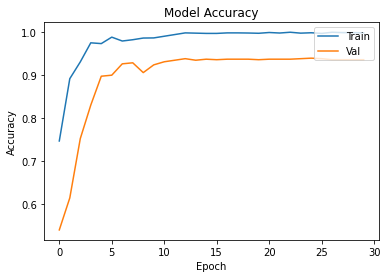

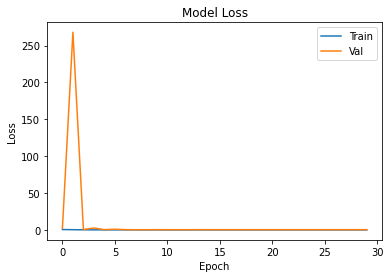

In [33]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

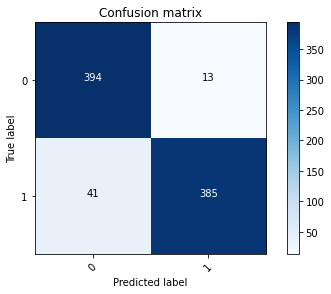

In [37]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [43]:
import os, datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from PIL import Image
import matplotlib.pyplot as plt

import pydotplus
import pydot

In [44]:
tf.keras.utils.pydot = pydot

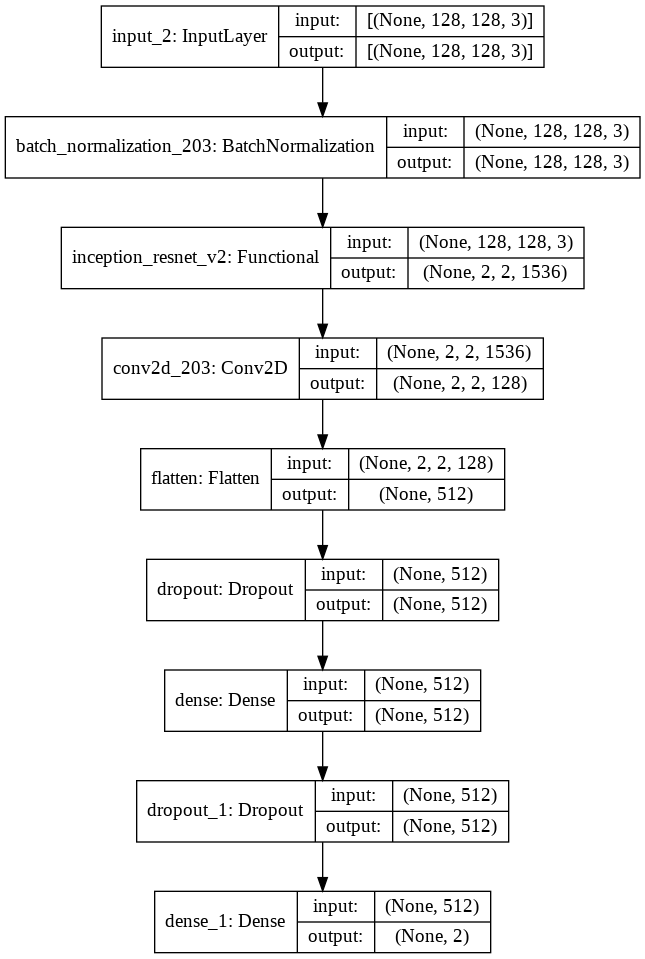

In [45]:
plot_model(model, to_file='model.png', show_shapes=True)